In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib.legend_handler import HandlerLine2D


import lightgbm as lgb 
!pip install --quiet optuna
import optuna
import sklearn.metrics
from optuna.integration import XGBoostPruningCallback
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.metrics import accuracy_score

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

for dirname, _, filenames in os.walk('/data_ML/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#parameters setting
start_release_year = 2008
speechiness_level = 0.66
corr_par = 0.1
seed = 42
ev_metric = 'rmse' # eval metric for xgb # 'rmse', 'error'...


Found GPU at: /device:GPU:0
/data_ML/input/artists.csv
/data_ML/input/tracks.csv


In [8]:
tracks_df = pd.read_csv('/data_ML/input/tracks.csv')
artists_df = pd.read_csv('/data_ML/input/artists.csv')
print(tracks_df.shape,artists_df.shape)

(586672, 20) (1162095, 5)


In [9]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [10]:
artists_df.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [11]:
tracks_df['id_artists'] = [i[2:-2] for i in tracks_df['id_artists']]
tracks_df['release_year'] = [int(i.split('-')[0]) for i in tracks_df['release_date']]
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


In [12]:
tracks_df = tracks_df[tracks_df['release_year']>=start_release_year]
tracks_df = tracks_df[tracks_df['speechiness']<speechiness_level]

In [13]:
artists_df.rename(columns = {'id': 'id_artists','popularity': 'artists_popularity'}, inplace = True)
artists_df.drop(['genres','name'],axis = 1, inplace = True)

In [14]:
tracks_df = tracks_df.merge(artists_df, on = 'id_artists')
del artists_df

In [15]:
tracks_df.drop(['id','id_artists','artists','name'], axis = 1, inplace = True)

In [16]:
tracks_df['release_date'] = pd.to_datetime(tracks_df['release_date'], format = '%Y-%m-%d')

In [17]:
tracks_df['delta_days'] = tracks_df['release_date'].max() - tracks_df['release_date']
tracks_df['delta_days'] = tracks_df['delta_days'].view(dtype = int)

In [18]:
tracks_df.isnull().sum() #no null values

popularity            0
duration_ms           0
explicit              0
release_date          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
release_year          0
followers             0
artists_popularity    0
delta_days            0
dtype: int64

In [19]:
corr = tracks_df.corr()

In [20]:
corr['popularity'][np.absolute(corr['popularity'])>corr_par].sort_values(ascending = False)

popularity            1.000000
artists_popularity    0.571956
followers             0.164017
explicit              0.150017
release_year          0.142030
danceability          0.119296
loudness              0.108960
delta_days           -0.138108
instrumentalness     -0.288239
Name: popularity, dtype: float64

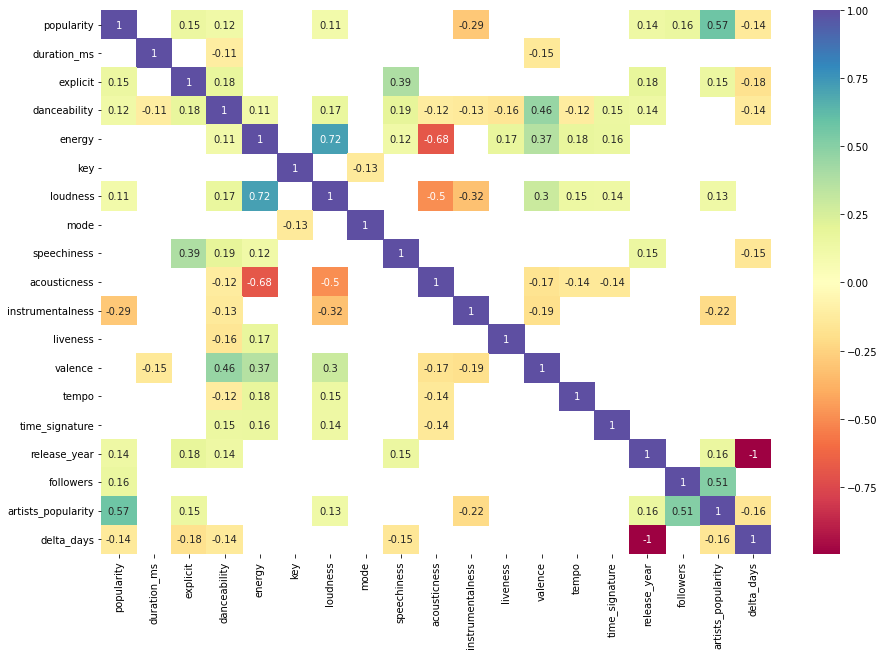

In [21]:
fig, ax = plt.subplots(figsize= (15,10))
sns.heatmap(corr[np.absolute(corr)>corr_par], annot = True, cmap='Spectral')

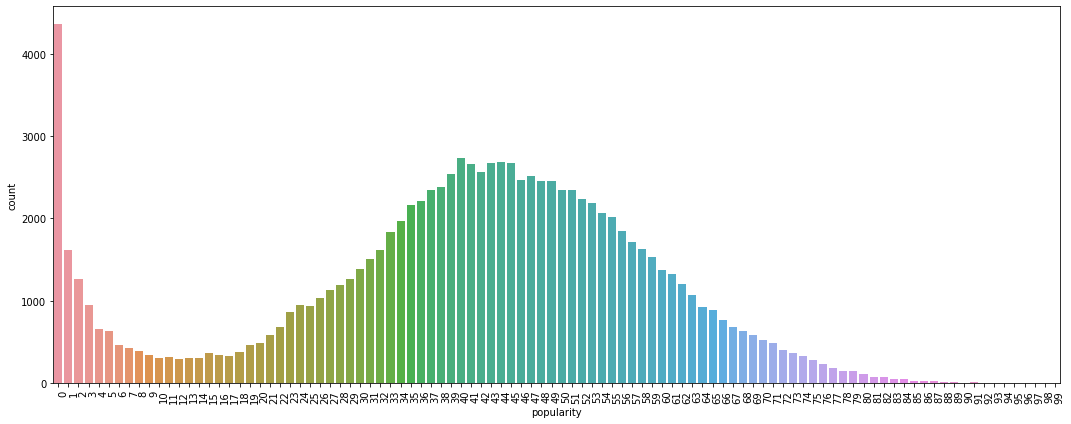

In [22]:
fig = plt.figure(figsize=(15,6))
fig.add_subplot(1,1,1)
ax = sns.countplot(data = tracks_df, x='popularity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="left")
plt.tight_layout()
plt.show()



In [23]:
features_columns = corr['popularity'][np.absolute(corr['popularity'])>corr_par].index.to_list()

print(f'Features used: {features_columns}')
print('')

X = tracks_df[features_columns].drop(['popularity'],axis = 1)
y = tracks_df['popularity']

Features used: ['popularity', 'explicit', 'danceability', 'loudness', 'instrumentalness', 'release_year', 'followers', 'artists_popularity', 'delta_days']



In [24]:
#Train and test dataset preparation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

del X, y

print(f'X_y_train shape: {X_train.shape} {y_train.shape}' )
print(f'X_y_test shape: {X_test.shape} {y_test.shape}' )

X_y_train shape: (81946, 8) (81946,)
X_y_test shape: (20487, 8) (20487,)


Decision Tree Classifier

Regression algorithms generally are used in presence of continuous values such as price, salary, etc., while Classification algorithms are used to predict/Classify the discrete values. Even if popularity are set as discrete variabile, it is more similar to continuous variable, therefore we expect a better performance on Regression algorithms

In [25]:
bonsai_c = tree.DecisionTreeClassifier(random_state=seed)
bonsai_c.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
bonsai_c_pred = bonsai_c.predict(X_test)
rmse_bonsai_c = mean_squared_error(y_test, bonsai_c_pred, squared=False)

print('---Decision Tree Classifier---')
print(f'Score: {bonsai_c.score(X_test,y_test)}')
print(f'Error: {(1-bonsai_c.score(X_test,y_test))*100:.4}%')
print(f'RMSE: {round(rmse_bonsai_c,4)}')


---Decision Tree Classifier---
Score: 0.07931859227802997
Error: 92.07%
RMSE: 14.2756


Decision Tree Regressor

In [27]:
bonsai_r = tree.DecisionTreeRegressor(random_state=seed)
bonsai_r.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [28]:
bonsai_r_pred = bonsai_r.predict(X_test)
rmse_bonsai_r = mean_squared_error(y_test, bonsai_r_pred, squared=False)

print('---Decision Tree Classifier---')
print(f'Score: {bonsai_r.score(X_test,y_test)}')
print(f'Error: {(1-bonsai_r.score(X_test,y_test))*100:.4}%')
print(f'RMSE: {round(rmse_bonsai_r,4)}')


---Decision Tree Classifier---
Score: 0.47072379397254704
Error: 52.93%
RMSE: 13.5916


Random Forest Classifier

In [29]:
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train,y_train)

clf_pred = clf.predict(X_test)
rmse_clf = mean_squared_error(y_test, clf_pred, squared=False)

print('---Random Forest Classifier---')
print(f'Score: {clf.score(X_test,y_test)}')
print(f'Error: {(1-clf.score(X_test,y_test))*100:.4}%')
print(f'RMSE: {round(rmse_clf,4)}')
print('')


---Random Forest Classifier---
Score: 0.09332747596036511
Error: 90.67%
RMSE: 12.7992



Random Forest Regression

In [30]:
train_results = []
test_results = []
train_score = []
test_score = []

list_nb_trees = [5, 10, 15, 30, 45, 60, 80, 100, 150, 200, 300]

print('---Random Forest Regressor---')

for nb_trees in list_nb_trees:
    rfr = RandomForestRegressor(n_estimators=nb_trees, random_state = seed)
    rfr.fit(X_train, y_train)

    train_results.append(mean_squared_error(y_train, rfr.predict(X_train), squared=False))
    test_results.append(mean_squared_error(y_test, rfr.predict(X_test), squared=False))
    train_score.append(rfr.score(X_train, y_train))
    test_score.append(rfr.score(X_test, y_test))

    rfr_pred = rfr.predict(X_test)
    rmse_rfr = mean_squared_error(y_test, rfr_pred, squared=False)
  
    print(f'---- For n_estimators = {nb_trees} ---')
    print(f'score: {rfr.score(X_test,y_test)}')
    print(f'Error: {(1-rfr.score(X_test,y_test))*100:.4}%')
    print(f'RMSE: {round(rmse_rfr,4)}')


---Random Forest Regressor---
---- For n_estimators = 5 ---
score: 0.6547478528890027
Error: 34.53%
RMSE: 10.9773
---- For n_estimators = 10 ---
score: 0.6873504987601602
Error: 31.26%
RMSE: 10.4462
---- For n_estimators = 15 ---
score: 0.6978058424720616
Error: 30.22%
RMSE: 10.27
---- For n_estimators = 30 ---
score: 0.7087440805871554
Error: 29.13%
RMSE: 10.0824
---- For n_estimators = 45 ---
score: 0.7131180739300045
Error: 28.69%
RMSE: 10.0064
---- For n_estimators = 60 ---
score: 0.7146499451332224
Error: 28.54%
RMSE: 9.9797
---- For n_estimators = 80 ---
score: 0.7168256795347054
Error: 28.32%
RMSE: 9.9416
---- For n_estimators = 100 ---
score: 0.7180123940330545
Error: 28.2%
RMSE: 9.9207
---- For n_estimators = 150 ---
score: 0.7184884207287583
Error: 28.15%
RMSE: 9.9123
---- For n_estimators = 200 ---
score: 0.7191392691185787
Error: 28.09%
RMSE: 9.9009
---- For n_estimators = 300 ---
score: 0.7200146429314541
Error: 28.0%
RMSE: 9.8854


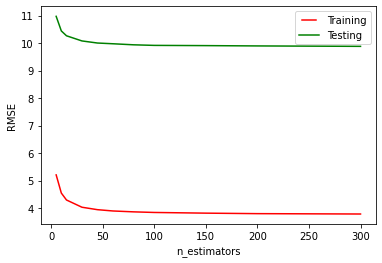

------------


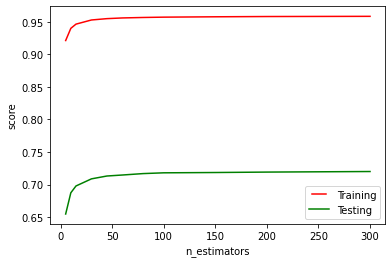

In [31]:
#Plot RMSE and score for different n_estimators

line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show()

print('------------')

line1, = plt.plot(list_nb_trees, train_score, color="r", label="Training")
line2, = plt.plot(list_nb_trees, test_score, color="g", label="Testing")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.show()

<BarContainer object of 8 artists>

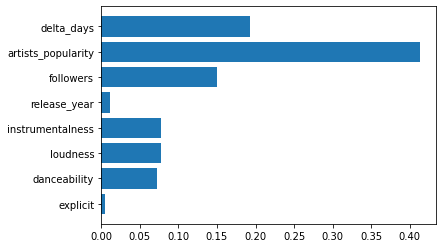

In [32]:
features = X_train.columns
plt.barh(y=features, width = rfr.feature_importances_)

XGB

In [33]:
def objective(trial):

  parameter = {
    'tree_method':'gpu_hist',  # using the GPU when training our model to speedup the training process
    "n_estimators" : trial.suggest_int('n_estimators', 1e-4, 500), # set integer parameters between 1e-3 and 500 for estimators
    'max_depth':trial.suggest_int('max_depth', 3,20), # set integer parameters between 3 and 20 for depth
    'alpha':trial.suggest_loguniform('alpha',1e-4,6), # set a log distribution between 1e-3 and 6 for alpha
    'lambda':trial.suggest_loguniform('lambda',1e-4,2), # set a log distribution between 1e-3 and 2 for lambda
    'min_child_weight':trial.suggest_int('min_child_weight',0,6), # show integer parameters between 0 and 1e-4 for childweight
    'gamma':trial.suggest_loguniform('gamma', 1e-4, 2), # set a log distribution between 1e-3 and 2 for gamma
    'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.25), # set a log distribution between 0.01 and 0.25 for learning rate
    'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.3,1), # set a uniformly distributed numbers between 0.3 and 1 for colsample_bytree
    'subsample':trial.suggest_uniform('subsample',0.4,1), #set a uniformly distributed numbers between 0.4 and 1 for colsample_bytree
    'random_state': trial.suggest_categorical('random_state', [seed]), #set random state
    'early_stopping_rounds': 150
  }

  mod = xgb.XGBRegressor(**parameter) 
  mod.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=False)
  preds = mod.predict(X_test)
  rmse = mean_squared_error(y_test, preds,squared=False)
      
  return rmse

In [ ]:
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [34]:
#############random_state = 42 early_stopping_round = 150################

#Best trial: {'n_estimators': 488, 
#'max_depth': 19, 
#'alpha': 0.003431371055296491, 
#'lambda': 0.754421617523184, 
#'min_child_weight': 4, 
#'gamma': 0.919210539476634, 
#'learning_rate': 0.012301994436985082, 
#'colsample_bytree': 0.9400077942818367, 
#'subsample': 0.9548337667235431, 
#'random_state': 42}

parameter = {
  'tree_method':'gpu_hist',  
  'n_estimators': 488, 
  'max_depth': 19, 
  'alpha': 0.003431371055296491, 
  'lambda': 0.754421617523184, 
  'min_child_weight': 4, 
  'gamma': 0.919210539476634, 
  'learning_rate': 0.012301994436985082, 
  'colsample_bytree': 0.9400077942818367, 
  'subsample': 0.9548337667235431, 
  'random_state': seed
  }

# fit model no training data
ev_metric = ['rmse', 'error']
xbg_model = xgb.XGBRegressor(**parameter)
eval_set = [(X_train, y_train), (X_test, y_test)]
xbg_model.fit(X_train, 
          y_train, 
          eval_metric = ev_metric , #'rmse',''error',...
          eval_set=eval_set, 
          verbose=False)

results = xbg_model.evals_result()

#xbg_model.fit(X_train, y_train)

# make predictions for test data
y_pred = xbg_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = xbg_model.score(X_test,y_test)
print("Score: %.2f%%" % (accuracy * 100.0))

[18:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score: 72.81%


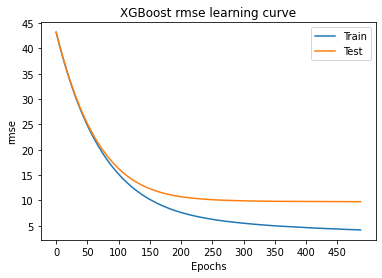

-------------------------


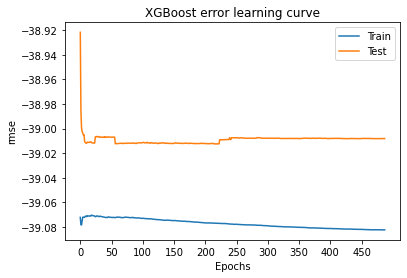

-------------------------


In [35]:
epochs = len(results['validation_0'][ev_metric[0]]) 
x_axis = range(0, epochs)

for i in ev_metric:
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0'][i], label='Train') 
  ax.plot(x_axis, results['validation_1'][i], label='Test') 
  ax.legend()
  plt.xlabel('Epochs')
  plt.ylabel('rmse')
  plt.title(f'XGBoost {i} learning curve')
  plt.xticks(np.arange(0, 500, 50))
  plt.show()

  print('-------------------------')

Outcome

In [36]:
print('--- Decision Tree Classifier ---')
print("Score: %.2f%%" % (bonsai_c.score(X_test,y_test) * 100.0))
print("")
print('--- Decision Tree Regressor ---')
print("Score: %.2f%%" % (bonsai_r.score(X_test,y_test) * 100.0))
print("")
print('--- Random Forest Classifier ---')
print("Score: %.2f%%" % (clf.score(X_test,y_test) * 100.0))
print("")
print('--- Random Forest Regressor ---')
print("Score: %.2f%%" %  (rfr.score(X_test,y_test) * 100.0))
print("")
print('--- XGB---')
print("Score: %.2f%%" % (xbg_model.score(X_test,y_test) * 100.0))


--- Decision Tree Classifier ---
Score: 7.93%

--- Decision Tree Regressor ---
Score: 47.07%

--- Random Forest Classifier ---
Score: 9.33%

--- Random Forest Regressor ---
Score: 72.00%

--- XGB---
Score: 72.81%
